<div  >
<img src="https://raw.githubusercontent.com/threeML/astromodels/master/docs/media/transp_logo.png" alt="drawing" width="300" align="right"/>
 


<div  >
<img src="https://raw.githubusercontent.com/threeML/threeML/master/logo/logo_sq.png" alt="drawing" width="300" align="right"/>



# Advanced Topics

Here we will cover a few more examples beyond jfust x-ray analsysis to get an idea of what is possible in 3ML.


 



## Joint Fits

We have learned to do x-ray analysis with 3ML, but one of the main purposes of 3ML is to allow joint fits with different types of data. To demostrate this, we will have a look at some simulated optical and x-ray data from a GRB afterglow observered by Chandra and the 7-Band GROND instrument.

<img src="https://room.eu.com/images/contents/GRBurst.jpg" alt="drawing" width="400" align="left"/>
<img src="https://cdn.eso.org/images/screen/eso0730a.jpg" alt="drawing" width="400" align="right"/>







In [1]:
from threeML import *


# get xspec models
#from astromodels.xspec import *
update_logging_level("INFO")
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

%matplotlib notebook
from jupyterthemes import jtplot
jtplot.style(context='notebook', fscale=1, ticks=True, grid=False)

from pathlib import Path

data_path = Path("joint_data")

Welcome to JupyROOT 6.22/02


[WARNING ] The naima package is not available. Models that depend on it will not be available
[WARNING ] The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.
[WARNING ] The ebltable package is not available. Models that depend on it will not be available
[INFO    ] Starting 3ML!
[WARNING ] no display variable set. using backend for graphics without display (agg)
[WARNING ] The cthreeML package is not installed. You will not be able to use plugins which require the C/C++ interface (currently HAWC)
[WARNING ] Could not import plugin HAWCLike.py. Do you have the relative instrument software installed and configured?



WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject







[WARNING ] Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML
[WARNING ] Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML
[WARNING ] Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML


### Photometric Data

Photometric data is handled in 3ML via the `PhotometricLike` plugin. We use the `speclite` package to interface to a variety of filters that come preloaded in 3ML. This is updated all the time, but it is already pretty extensive. If you want to use the filters, you need to load them manually:


In [2]:
import speclite.filters as spec_filters

from threeML.utils.photometry import PhotometericObservation
# The filter library takes a while to load so you must import it explicitly.
from threeML.utils.photometry import get_photometric_filter_library

threeML_filter_library = get_photometric_filter_library()

Loading photometric filters:   0%|                                      | 0/149 [00:00<?, ?it/s]

Let's get the filters for GROND and have a look

In [ ]:
grond_filters = threeML_filter_library.LaSilla.GROND

In [ ]:
spec_filters.plot_filters(grond_filters)

The shapes of the filters are important. Many times, astronomers try to convert magnitude to counts via multiplying by the average filter response. This causes the errors to become inaccurate. 3ML works directly in magnitude space via *synthetic photometry*, i.e., forward folding the photon model into the filter response to provide more accurate fits. 


There are several ways to load data into the plugin.

1) via keywords where data are passed as tuples of magnitudes and uncertainties with the keyword being the band name:

In [ ]:
grond_observation = PhotometericObservation.from_kwargs(g=(21.5,0.02),
                                                        r=(22.,0.03),
                                                        i=(21.8, 0.01),
                                                        z=(21.2, 0.01),
                                                        J=(19.6, 0.1),
                                                        H=(18.6, 0.01),
                                                        K=(18.0, 0.1))

grond_observation

2) via an HDF5 file type in 3ML that stores the data:

In [ ]:
grond_observation = PhotometericObservation.from_hdf5("joint_data/grond_data.h5")

We can then load these observation into the plugin, or we could use the helper functions to do this directly

In [ ]:
grond = PhotometryLike.from_file("grond",grond_filters,file_name="joint_data/grond_data.h5",)
grond.plot();

We can see what data are in the plugin:

In [ ]:
grond.band_J

and we can turn the bands on and off for the fit:

In [ ]:
grond.band_J.off = True

In [ ]:
grond.band_J

In [ ]:
grond.band_J.on = True

In [ ]:
grond.band_J

### X-ray data

Now we can load our x-ray data as we always do:


In [ ]:
chandra = OGIPLike("chandra",observation="joint_data/obs_demo.pha", spectrum_number=1)

chandra.set_active_measurements("1-10")

chandra.rebin_on_background(1)

chandra.view_count_spectrum();


### Performing a joint fit

To do a joint fit, everything is the same as before except that now our DataList fits a little bigger


In [ ]:
data = DataList(grond, chandra)

This time we will use maximum likelihood for the fun of it. GRB afterglows are typically characterized as broken power laws to approximate their synchrotron radiation. Let's build a model for that:

In [ ]:
bpl = Broken_powerlaw(K=1, piv=1)

# set some reasonable bounds on the break energy
bpl.xb.bounds = (0, None)

ps = PointSource("grb", 0,0, spectral_shape=bpl)


model = Model(ps)

In [ ]:
jl = JointLikelihood(model, data)

# let's use the ROOT minimizer
jl.set_minimizer("ROOT")

In [ ]:
_ = jl.fit()

Because these data live in different spaces, they have different x-axes. Thus, we have to plot the data fits with different functions:

In [ ]:
display_spectrum_model_counts(jl, min_rate=10);

In [ ]:
display_photometry_model_magnitudes(jl);

Of course, we can always look at the model space:

In [ ]:
plot_spectra(jl.results, ene_min =25000 * u.Angstrom, ene_max = 1.239842* u.Angstrom, energy_unit=u.Angstrom  , flux_unit="erg/s/cm2/keV");

But maybe it is a power law?

In [ ]:
pl = Powerlaw(K=1, piv=1)

ps_pl = PointSource("grb_pl", 0,0, spectral_shape=pl)
model_pl = Model(ps_pl)

In [ ]:
jl_pl = JointLikelihood(model_pl, data)

In [ ]:
jl_pl.set_minimizer("ROOT")

In [ ]:
_ = jl_pl.fit(quiet=False)

In [ ]:
plot_spectra(jl.results, jl_pl.results ,ene_min =25000 * u.Angstrom, ene_max = 1.239842* u.Angstrom, energy_unit=u.Angstrom  , flux_unit="erg/s/cm2/keV");

In [ ]:
lrt = LikelihoodRatioTest(jl_pl,jl)

In [ ]:
with parallel_computation(start_cluster=True):

    lrt.by_mc(100, continue_on_failure=True)

In [ ]:
lrt.plot_TS_distribution(bins=100, ec="k", fc="white", lw=1.2)
_ = plt.legend()

## Complex Models


### Generating some synthetic data

![alt text](http://aasnova.org/wp-content/uploads/2016/03/fig16.jpg)

Let's say we have two galactic x-ray sources, some accreting compact binaries perhaps? We observe them at two different times. These sources (imaginary) sources emit a blackbody which is theorized to always be at the same temperature, but perhaps at different flux levels.


Lets simulate one of these sources:




In [3]:
from threeML.utils.OGIP.response import OGIPResponse
from threeML.io.package_data import get_path_of_data_file

[WARNING ] The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: None
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: None
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: poisson
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: poisson


<IPython.core.display.Javascript object>


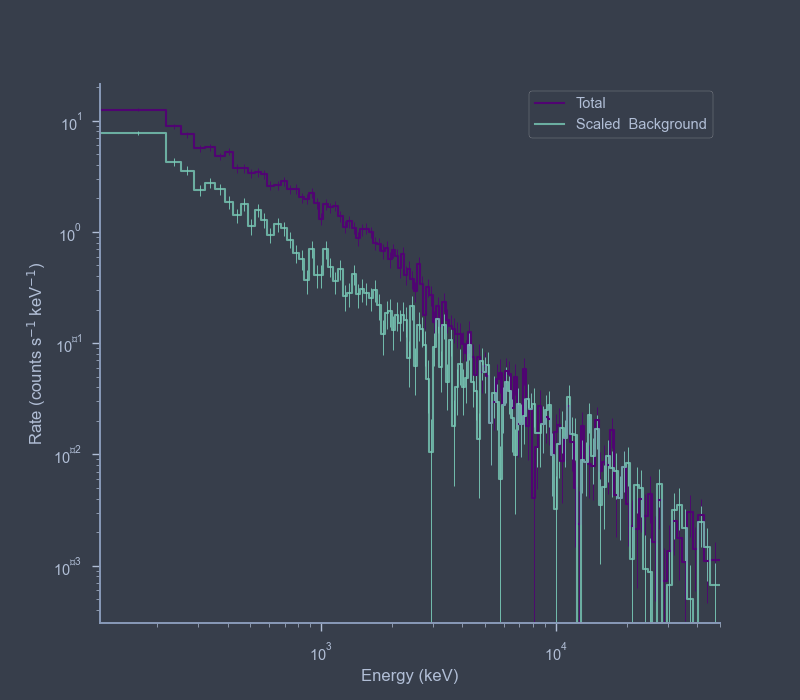

In [4]:
np.random.seed(1234)

# we will use a demo response
response_1 = OGIPResponse(get_path_of_data_file("datasets/ogip_powerlaw.rsp"))


source_function_1 = Blackbody(K=5e-8, kT=500.0)
background_function_1 = Powerlaw(K=1, index=-1.5, piv=1.0e3)


spectrum_generator_1 = DispersionSpectrumLike.from_function(
    "s1",
    source_function=source_function_1,
    background_function=background_function_1,
    response=response_1,
)

fig = spectrum_generator_1.view_count_spectrum()

Now let's simulate the other source, but this one has an extra feature! There is a power law component in addition to the blackbody. 

[WARNING ] The default choice for MATRIX extension failed:KeyError("Extension ('MATRIX', 1) not found.")available: None 'EBOUNDS' 'SPECRESP MATRIX'
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: None
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: None
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: poisson
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: poisson


<IPython.core.display.Javascript object>


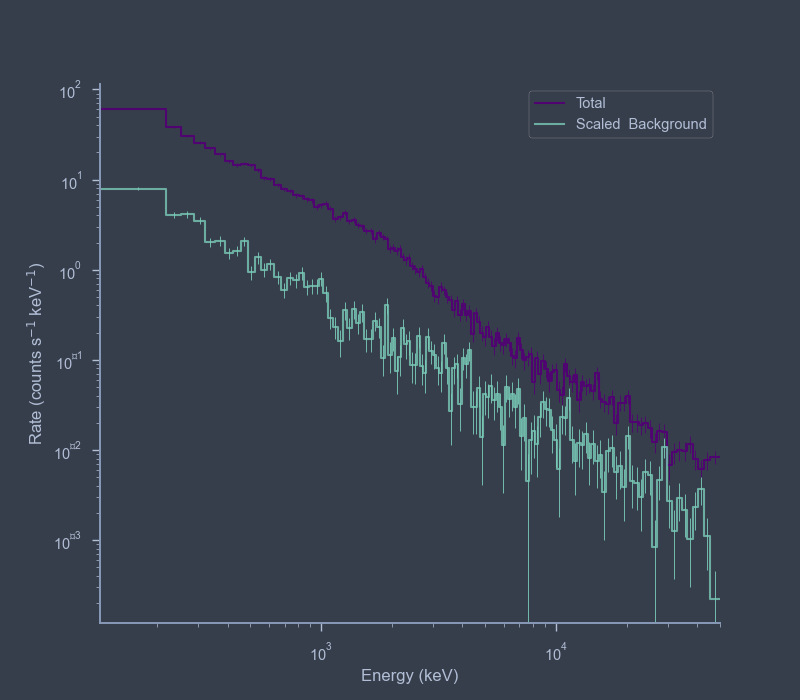

In [5]:
response_2 = OGIPResponse(get_path_of_data_file("datasets/ogip_powerlaw.rsp"))


source_function_2 = Blackbody(K=1e-7, kT=500.0) + Powerlaw_flux(
    F=2e2, index=-1.5, a=10, b=500
)
background_function_2 = Powerlaw(K=1, index=-1.5, piv=1.0e3)


spectrum_generator_2 = DispersionSpectrumLike.from_function(
    "s2",
    source_function=source_function_2,
    background_function=background_function_2,
    response=response_2,
)

fig = spectrum_generator_2.view_count_spectrum()

### Make the model

Now let's make the model we will use to fit the data. First, let's make the spectral function for source_1 and set priors on the parameters.



In [6]:
spectrum_1 = Blackbody()

spectrum_1.K.prior = Log_normal(mu=np.log(1e-7), sigma=1)
spectrum_1.kT.prior = Log_normal(mu=np.log(300), sigma=2)

ps1 = PointSource("src1", ra=1, dec=20, spectral_shape=spectrum_1)

We will do the same for the other source but also include the power law component 

In [8]:
spectrum_2 = Blackbody() + Powerlaw_flux(
    a=10, b=500
)  # a,b are the bounds for the flux for this model

spectrum_2.K_1.prior = Log_normal(mu=np.log(1e-6), sigma=1)
spectrum_2.kT_1.prior = Log_normal(mu=np.log(300), sigma=2)

spectrum_2.F_2.prior = Log_normal(mu=np.log(1e2), sigma=1)
spectrum_2.F_2.bounds = (None, None)

spectrum_2.index_2.prior = Gaussian(mu=-1.0, sigma=1)
spectrum_2.index_2.bounds = (None, None)

ps2 = PointSource("src2", ra=2, dec=-10, spectral_shape=spectrum_2)

[WARNING ] We have set the min_value of composite.F_2 to 1e-99 because there was a postive transform
[WARNING ] We have set the min_value of composite.F_2 to 1e-99 because there was a postive transform


In [9]:
model = Model(ps1, ps2)


### Linking parameters

We hypothesized that both sources should have the a same blackbody temperature. We can impose this by linking the temperatures. 



In [11]:
model.link(
    model.src1.spectrum.main.Blackbody.kT, model.src2.spectrum.main.composite.kT_1
)

we could also link the parameters with an arbitrary function rather than directly. Check out the [astromodels documentation](https://astromodels.readthedocs.io/en/latest/Model_tutorial.html#linking-parameters) for more details.

In [10]:
model


Model summary:
==============

                  N
Point sources     2
Extended sources  0
Particle sources  0

Free parameters (6):
--------------------

                                       value min_value max_value  \
src1.spectrum.main.Blackbody.K        0.0001       0.0      None   
src1.spectrum.main.Blackbody.kT         30.0       0.0      None   
src2.spectrum.main.composite.K_1      0.0001       0.0      None   
src2.spectrum.main.composite.kT_1       30.0       0.0      None   
src2.spectrum.main.composite.F_2         1.0       0.0      None   
src2.spectrum.main.composite.index_2    -2.0      None      None   

                                                unit  
src1.spectrum.main.Blackbody.K        s-1 cm-2 keV-3  
src1.spectrum.main.Blackbody.kT                  keV  
src2.spectrum.main.composite.K_1      s-1 cm-2 keV-3  
src2.spectrum.main.composite.kT_1                keV  
src2.spectrum.main.composite.F_2            s-1 cm-2  
src2.spectrum.main.composite.index_2                  

Fixed parameters (6):
(abridged. Use complete=True to see all fixed parameters)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

### Assigning sources to plugins

Now, if we simply passed out model to the BayesianAnalysis or JointLikelihood objects, it would sum the point source spectra together and apply both sources to all data. 

This is not what we want. Many plugins have the ability to be assigned directly to a source. Let's do that here:

In [12]:
spectrum_generator_1.assign_to_source("src1")

spectrum_generator_2.assign_to_source("src2")

Now we simply make our our data list

In [13]:
data = DataList(spectrum_generator_1, spectrum_generator_2)


### Fitting the data

Now we fit the data as we normally would. We use Bayesian analysis here.

In [15]:
ba = BayesianAnalysis(model, data)
ba.set_sampler("multinest")
ba.sampler.setup(n_live_points=500)
#ba.sampler.setup(frac_remain=0.5)
_ = ba.sample()

[WARNING ] External parameter cons_s1 already exist in the model. Overwriting it...
[WARNING ] External parameter cons_s2 already exist in the model. Overwriting it...
[INFO    ] sampler set to multinest
  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
src1.spectrum.main.Blackbody.K,(4.68 -0.30 +0.31) x 10^-8,1 / (cm2 keV3 s)
src2.spectrum.main.composite.K_1,(9.7 +/- 0.7) x 10^-8,1 / (cm2 keV3 s)
src2.spectrum.main.composite.kT_1,(5.10 -0.09 +0.10) x 10^2,keV
src2.spectrum.main.composite.F_2,(2.06 +/- 0.07) x 10^2,1 / (cm2 s)
src2.spectrum.main.composite.index_2,-1.510 +/- 0.010,



Values of -log(posterior) at the minimum:



,-log(posterior)
s1,-604.851247
s2,-699.298072
total,-1304.149318



Values of statistical measures:



,statistical measures
AIC,2618.538637
BIC,2636.024524
DIC,2629.500808
PDIC,5.134204
log(Z),-581.351489


 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    5
 *****************************************************

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging toward

Let's examine the fits.

<IPython.core.display.Javascript object>


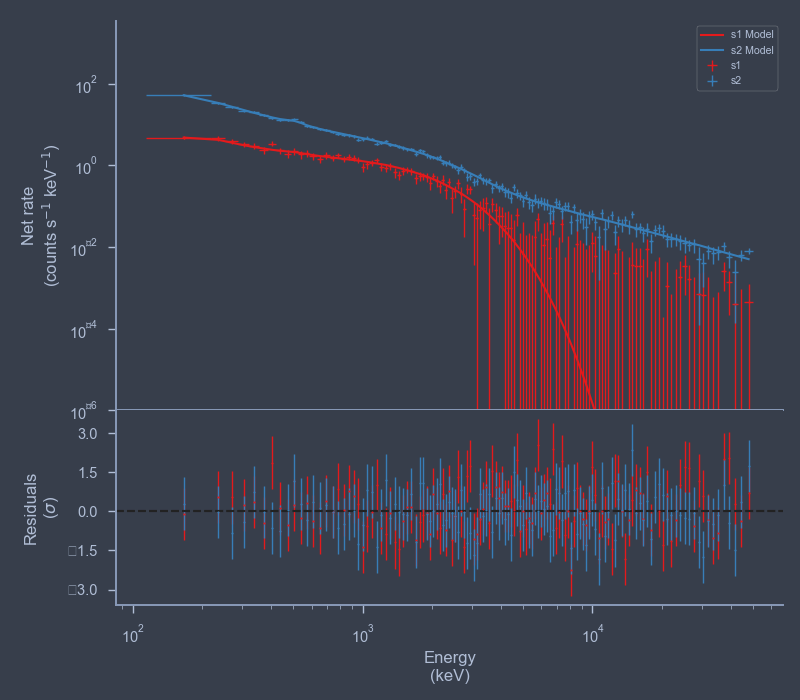


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a

(1e-06, 3487.3458581647305)

In [16]:
fig = display_spectrum_model_counts(ba)
ax = fig.get_axes()[0]
ax.set_ylim(1e-6)

Lets grab the result. Remember, we can save the results to disk, so all of the following operations can be run at a later time without having to redo all the above steps!


WARNING MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()



<IPython.core.display.Javascript object>


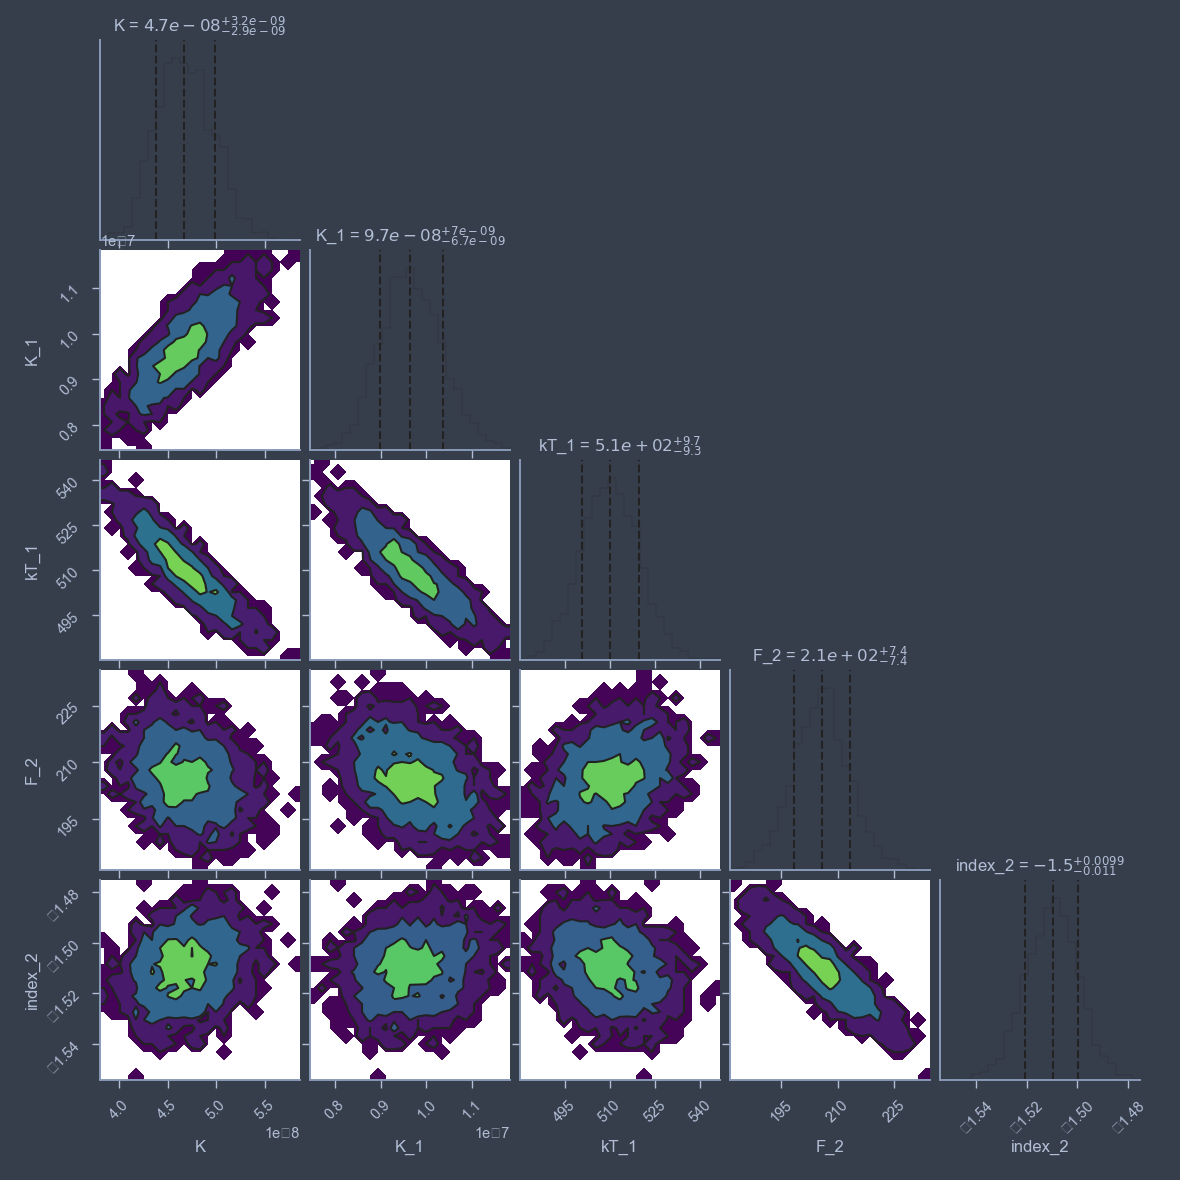

In [17]:
result = ba.results
fig = result.corner_plot()


## Computing fluxes

Now we will compute fluxes. We can compute them an many different units, over any energy range also specified in any units. 

The flux is computed by integrating the function over energy. By default, a fast trapezoid method is used. If you need more accuracy, you can change the method in the configuration.

In [36]:
silence_warnings()

# we could also use 'quad' here, but it is slower

threeML_config.point_source.integrate_flux_method = "trapz"

result.get_flux(ene_min=1 * u.keV, ene_max=1 * u.MeV, flux_unit="erg/cm2/s")

processing Bayesian analyses:   0%|                                       | 0/2 [00:00<?, ?it/s]

,flux,low bound,hi bound
src1: total,5.704656309330517e-06 erg / (cm2 s),5.354195939667404e-06 erg / (cm2 s),6.095712009680491e-06 erg / (cm2 s)
src2: total,4.843153751518272e-05 erg / (cm2 s),4.7736845649327966e-05 erg / (cm2 s),4.920918235527676e-05 erg / (cm2 s)


We see that a pandas dataframe is returned with all the information. We could change the confidence region for the uncertainties if we desire. However, we could also sum the source fluxes! 3ML will take care of propagating the uncertainties (for any of these operations). 

In [37]:


result.get_flux(
    ene_min=1 * u.keV,
    ene_max=1 * u.MeV,
    confidence_level=0.95,
    sum_sources=True,
    flux_unit="erg/cm2/s",
)

processing Bayesian analyses:   0%|                                       | 0/2 [00:00<?, ?it/s]

,flux,low bound,hi bound
total,5.4141804926180764e-05 erg / (cm2 s),5.2552811610211506e-05 erg / (cm2 s),5.5886419362449226e-05 erg / (cm2 s)


We can get the fluxes of individual components:

In [23]:
result.get_flux(
    ene_min=10 * u.keV, ene_max=0.5 * u.MeV, use_components=True, flux_unit="1/(cm2 s)"
)

processing Bayesian analyses:   0%|                                       | 0/2 [00:00<?, ?it/s]

,flux,low bound,hi bound
src1: total,2.122119324739992 1 / (cm2 s),1.991748854953549 1 / (cm2 s),2.2675911662960004 1 / (cm2 s)
src2: Blackbody,4.384250010402028 1 / (cm2 s),4.1688841031360155 1 / (cm2 s),4.598318199798245 1 / (cm2 s)
src2: Powerlaw_flux,219.53365757415895 1 / (cm2 s),211.38135959938273 1 / (cm2 s),227.69719238510436 1 / (cm2 s)


As well as choose which component to compute

In [39]:
result.get_flux(ene_min=10*u.keV, 
                ene_max = 0.5*u.MeV,
                use_components=True,
                components_to_use =["Blackbody"],
                
                flux_unit="erg2/(cm2 s)")

processing Bayesian analyses:   0%|                                       | 0/2 [00:00<?, ?it/s]

,flux,low bound,hi bound
src1: total,6.316354301787592e-13 erg2 / (cm2 s),5.928314822545507e-13 erg2 / (cm2 s),6.749342061471572e-13 erg2 / (cm2 s)
src2: Blackbody,1.304952967820263e-12 erg2 / (cm2 s),1.2427956326521105e-12 erg2 / (cm2 s),1.366813302726508e-12 erg2 / (cm2 s)


Finally, the returned flux object is a pandas table and can be manipulated as such:

In [33]:
flux = result.get_flux(ene_min=1 * u.keV, ene_max=1 * u.MeV, flux_unit="J2/m2/yr")


processing Bayesian analyses:   0%|                                       | 0/2 [00:00<?, ?it/s]

In [34]:
flux["flux"]

src1: total    2.0297717599226623e-14 J2 / (m2 yr)
src2: total    1.0490725080020785e-13 J2 / (m2 yr)
Name: flux, dtype: object

In [35]:
flux["flux"]["src1: total"]


<Quantity 2.02977176e-14 J2 / (m2 yr)>